In [ ]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torchvision.transforms as transforms
import torchvision.models as models

import copy
import requests
from io import BytesIO

# Disclaimer
Most of this code is modified from Alexis Jacq's work (their tutorial can be found [here](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html#neural-transfer-using-pytorch)). Parts are also inspired by [Greg Surma's implementation](https://towardsdatascience.com/style-transfer-styling-images-with-convolutional-neural-networks-7d215b58f461) and the original [Gatys et al. paper](https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Gatys_Image_Style_Transfer_CVPR_2016_paper.html) that introduced neural style transfer.

### To do:
+ Figure out which hyperparameters are important
+ How to use GPU through Colab

In [ ]:
# Hyperparameters
imsize = 512 if torch.cuda.is_available() else 224  # use small size if no gpu
## Will add here, probably

# Device (only using cpu for now, not sure how to use gpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pick your style and content images here
style_img_path = "https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg"
content_img_path = "https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg"


imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([ # A NORMALIZATION STEP COULD GO HERE
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

# Load an image from a URL
def image_loader(image_name):
    image = Image.open(BytesIO(requests.get(image_name).content))
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader(style_img_path)
content_img = image_loader(content_img_path)

This next cell only helps visualize the images to ensure they were imported correctly, but I don't feel the need to leave this in for the final version (useful for testing but can also just type 'style_img' and 'content_img' inline to display each image)

### To do:
+ Figure out how to manipulate and normalize images
  + PIL, scikit-image(?), numpy

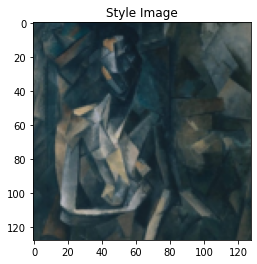

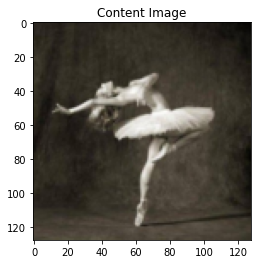

In [ ]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

# Defining optimization functions

## Content loss

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach() # Detaching is like making a temporary copy

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target) # recall that F is torch.nn.functional
        return input

## Style loss
Below is an implementation of the Gram Matrix (that I don't understand...) from [the PyTorch tutorial](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html#style-loss). 

**From the tutorial:**

"In order to calculate the style loss, we need to compute the gram matrix G<sub>XL</sub>. A gram matrix is the result of multiplying a given matrix by its transposed matrix. In this application the given matrix is a reshaped version of the feature maps F<sub>XL</sub> of a layer L. F<sub>XL</sub> is reshaped to form F^<sub>XL</sub>, a KxN matrix, where K is the number of feature maps at layer L and N is the length of any vectorized feature map F<sup>K</sup><sub>XL</sub>. For example, the first line of F^<sub>XL</sub> corresponds to the first vectorized feature map F<sup>1</sup><sub>XL</sub>"

**Questions on Gram matrix/Style loss:**

+ Can I find a more intuitive/visual representation of the gram matrix used here?
+ What is K? i.e. What is the number of feature maps?
  + F<sub>XL</sub> is the set of all feature maps for the layer L, it is then reshaped to be K by N (from which shape?). 
  + It seems like (from the Normalization step), that K corresponds to the number of channels (i.e. 3)
+ How exactly is the Gram matrix useful to calculate Style Loss?
+ 

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()
    # a=batch size(=1)
    # b=number of feature maps (i.e. K in the explanation above)
    # (c,d)=dimensions of a feature map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

**On normalisation (from the same tutorial):**

"This normalization is to counteract the fact that F^<sub>XL</sub> matrices with a large N dimension yield larger values in the Gram matrix. These larger values will cause the first layers (before pooling layers) to have a larger impact during the gradient descent. **Style features tend to be in the deeper layers** of the network so this normalization step is crucial."

In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

# Import the model

Info on VGG19 found [here](https://keras.io/api/applications/vgg/#vgg16-function) (this info is for TensorFlow). 

Note (from PyTorch tutorial): "Additionally, VGG networks are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. We will use them to normalize the image before sending it into the network."

### Questions:
+ The [Tensorflow version](https://towardsdatascience.com/style-transfer-styling-images-with-convolutional-neural-networks-7d215b58f461) of this specified that the images need to be reshaped from RGB to BGR. Why? Where does this implementation do it?

### To do:
+ Figure out normalization and make it more intuitive!

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()
cnn_16 = models.vgg16(pretrained=True).features.to(device).eval() # Import VGG16 as well, to compare performance later

## Normalization

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

## Reorder modules and layers

From the tutorial: "vgg19.features contains a sequence (Conv2d, ReLU, MaxPool2d, Conv2d, ReLU…) aligned in the right order of depth. **We need to add our content loss and style loss layers immediately after the convolution layer they are detecting**. To do this we must create a new Sequential module that has content loss and style loss modules correctly inserted."

**Questions:**
+ How many of each kind of layer does VGG19 have?
  + It has 19 weight layers (i.e. feature extraction part of the model). 

![VGG19 architecture](https://miro.medium.com/max/700/1*-lIw_z6HEPHaGSpSOhyBow.png)

+ Does a Convolution layer always come with a ReLU layer? Why?

Note on layers to use:

[Johnson et al.](https://arxiv.org/abs/1603.08155) say to use block2_conv2 for content and [block1_conv2, block2_conv2, block3_conv3, block4_conv3, block5_conv3] for style.
+ What are the blocks here? The below implementation doesn't take them into account.

### To do:
+ Figure out what difference do blocks make.

In [ ]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

# Optimization

## Selecting the input image
We take a copy of the content image to use it as the input for optimization (i.e. the content and style will be applied to it, but we can simply use our content image here).

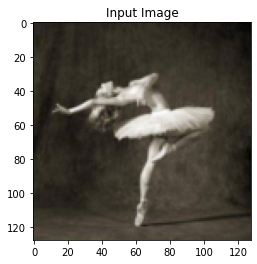

In [ ]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

## Gradient descent

Essentially, we want to minimize the difference between the style of the output and the style of the style image, and the difference between the content of the output and the content of the content image.

Notes on the algorithm used: I accidentally deleted all my notes for this section :(

### To do:
+ Dig through the 3 blog articles and Gatys paper for notes on algorithm (including usage of layers)



In [ ]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

## Style transfer function

Note: The weight on the style is much heavier because we want the style to be prominent.

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

## Running the algorithm

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [50]:
Style Loss : 1.617486 Content Loss: 7.047743

run [100]:
Style Loss : 1.590935 Content Loss: 6.931086

run [150]:
Style Loss : 1.561002 Content Loss: 6.830297

run [200]:
Style Loss : 1.537233 Content Loss: 6.736264

run [250]:
Style Loss : 1.517043 Content Loss: 6.658101

run [300]:
Style Loss : 1.497705 Content Loss: 6.596681



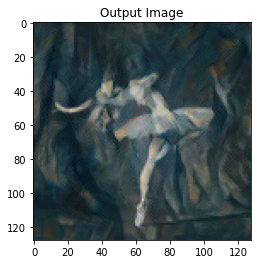

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')